Select a dataset with a continuous target variable.

Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.


In [1]:
import numpy as np
import pandas as pd
import wrangle
import explore
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

In [2]:
df = wrangle.wrangle_zillow()

In [3]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,year,tax_amount,fips
4,4,2.0,3633.0,296425.0,2005,6941.39,6037
18,3,1.0,1244.0,169471.0,1950,2532.88,6037
19,3,2.0,1300.0,233266.0,1950,3110.99,6037
20,3,2.0,1222.0,290492.0,1951,3870.25,6037
23,3,2.5,1821.0,537949.0,2013,6173.72,6059


In [4]:
train, validate, test = wrangle.split_data(df)

In [5]:
train.shape, validate.shape, test.shape

((999228, 7), (333076, 7), (333076, 7))

In [6]:
X_train, y_train = train.drop(columns='tax_value'), train.tax_value
X_validate, y_validate = validate.drop(columns='tax_value'), validate.tax_value
X_test, y_test = test.drop(columns='tax_value'), test.tax_value

(array([ 58071., 124991., 111190., 139198., 136087., 120972., 103425.,
         87181.,  65863.,  52250.]),
 array([  2080. ,  61871.5, 121663. , 181454.5, 241246. , 301037.5,
        360829. , 420620.5, 480412. , 540203.5, 599995. ]),
 <BarContainer object of 10 artists>)

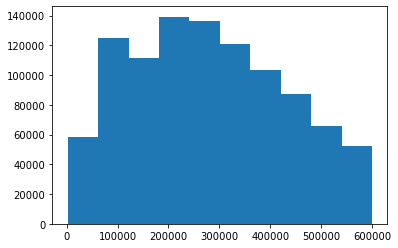

In [7]:
plt.hist(y_train)

In [8]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [9]:
value_pred_mean = y_train.tax_value.mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

In [10]:
value_pred_median = y_train.tax_value.median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

In [11]:
y_train

,tax_value,value_pred_mean,value_pred_median
864307,514069.0,280186.669215,269749.0
1433067,326561.0,280186.669215,269749.0
1170762,266050.0,280186.669215,269749.0
1694318,105567.0,280186.669215,269749.0
149423,356406.0,280186.669215,269749.0
...,...,...,...
225835,177461.0,280186.669215,269749.0
1373371,59633.0,280186.669215,269749.0
1706108,114452.0,280186.669215,269749.0
1477602,109033.0,280186.669215,269749.0


In [12]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  149439.38 
Validate/Out-of-Sample:  149483.22


In [13]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  149803.45 
Validate/Out-of-Sample:  149841.13


In [14]:
metric_df = pd.DataFrame(
data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.tax_value,
                                           y_validate.value_pred_mean)
}])

In [15]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,149841.131498,0.0


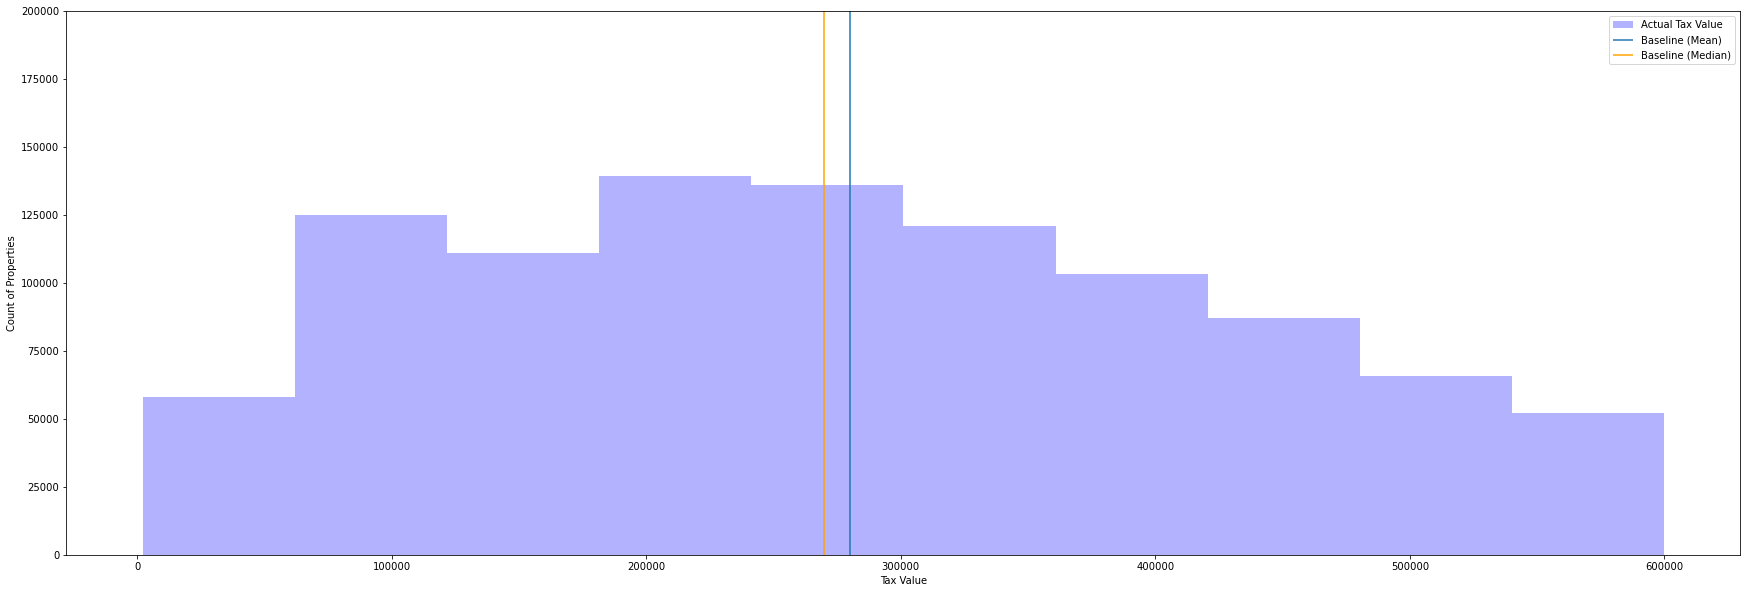

In [16]:
plt.figure(figsize=[30,10])
plt.hist(y_train.tax_value, color='blue', alpha=0.3, label='Actual Tax Value')
plt.vlines(y_train.tax_value.mean(), ymin=0, ymax=200000, label='Baseline (Mean)')
plt.vlines(y_train.tax_value.median(), ymin=0, ymax=200000, color='orange', label='Baseline (Median)')
plt.xlabel('Tax Value')
plt.ylabel('Count of Properties')
plt.ylim(top=200000)
plt.legend()
plt.show()

In [17]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [18]:
lm = LinearRegression()

lm.fit(X_train_scaled, y_train.tax_value)

y_train['value_pred_lm'] = lm.predict(X_train_scaled)
y_validate['value_pred_lm'] = lm.predict(X_validate_scaled)

rmse_train = mean_squared_error(y_train.tax_value,
                               y_train.value_pred_lm) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value,
                               y_validate.value_pred_lm) ** 0.5

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  38755.38346128042 
Validation/Out-of-Sample:  38748.15268753245


In [19]:
metric_df = metric_df.append(
{
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.tax_value,
                                           y_validate.value_pred_lm)
}, ignore_index=True)


/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_14322/2060126797.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [20]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,149841.131498,0.000000
1,OLS lm 1,38748.152688,0.932808


In [21]:
# create the model object
lars = LassoLars()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!

lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train_scaled)
y_validate['value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
# predict validate
# evaluate: rmse

rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lars) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lars) ** 0.5


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  38881.48757901063 
Validation/Out-of-Sample:  38871.172182089984


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [22]:
metric_df = metric_df.append(
{
    'model': 'LassoLars',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.tax_value,
                                           y_validate.value_pred_lars)
}, ignore_index=True)


/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_14322/166987391.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [23]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,149841.131498,0.000000
1,OLS lm 1,38748.152688,0.932808
2,LassoLars,38871.172182,0.932381


In [24]:
# create the model object
glm = TweedieRegressor()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!

glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train_scaled)
y_validate['value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
# predict validate
# evaluate: rmse

rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  142608.6474808453 
Validation/Out-of-Sample:  142650.17136694427


In [25]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.value_pred_glm)}, ignore_index=True)

/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_14322/4188985649.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [26]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,149841.131498,0.000000
1,OLS lm 1,38748.152688,0.932808
2,LassoLars,38871.172182,0.932381
3,GLM Model power 1,142650.171367,0.089333


In [27]:
# make the polynomial features to get a new set of features

pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [28]:
lm2 = LinearRegression(normalize=True)

lm2.fit(X_train_degree2, y_train.tax_value)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [29]:
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2) ** 0.5

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  36694.98172498368 
Validation/Out-of-Sample:  36690.18112970401


In [30]:
metric_df = metric_df.append(
    {
    'model': 'Quadratic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.value_pred_lm2)}, ignore_index=True)

/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_14322/74796615.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [31]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,149841.131498,0.000000
1,OLS lm 1,38748.152688,0.932808
2,LassoLars,38871.172182,0.932381
3,GLM Model power 1,142650.171367,0.089333
4,Quadratic Model,36690.181130,0.939756


In [32]:
y_pred_test = lm2.predict(X_test_degree2)

In [33]:
rmse_test = mean_squared_error(y_test, y_pred_test) ** 0.5

In [34]:
rmse_test

36554.68900219493

In [35]:
rmse_score = explained_variance_score(y_test, y_pred_test) ** 0.5

In [36]:
rmse_score

0.9696799703093564